# Preliminaries

In [1]:
from dissipationtheory.constants import ureg, qe, epsilon0
from dissipationtheory.dissipation9a import CantileverModel, SampleModel3
from dissipationtheory.dissipation9b import SampleModel3Jit
from dissipationtheory.dissipation13e import twodimCobject as twodimCobjectPrior
from dissipationtheory.dissipation14e import get_device, rp_III_integrator, Cmatrix
from dissipationtheory.dissipation14e import twodimCobject, comparetwoK

In [2]:
import torch
import numpy as np
import matplotlib.pylab as plt

In [300]:
from lmfit import Model, Parameters

In [3]:
THIS = 'dissipation-theory--Study-69--'
figs = {}
t = {}

# Calculate the BLDS spectrum on the CPU

In [4]:
device = get_device(verbose=True)

cantilever = CantileverModel(
    f_c=ureg.Quantity(62, "kHz"),
    k_c=ureg.Quantity(2.8, "N/m"),
    V_ts=ureg.Quantity(1, "V"),
    R=ureg.Quantity(60, "nm"),
    angle=ureg.Quantity(20, "degree"),
    L=ureg.Quantity(1000, "nm"),
)

sample3 = SampleModel3(
    cantilever=cantilever,
    epsilon_s=ureg.Quantity(complex(3, 0), ""),
    sigma=ureg.Quantity(1e-6, "S/m"),
    rho=ureg.Quantity(1e21, "1/m^3"),
    z_r=ureg.Quantity(1, "nm"),
)

device = get_device()

Using MPS (Apple Silicon GPU)


In [5]:
sample3_jit = SampleModel3Jit(**sample3.args())

obj1 = twodimCobjectPrior(sample3_jit)
obj1.addsphere(ureg.Quantity(100,'nm'), 21, 24)
obj1.set_alpha(1.0e-6)
obj1.set_breakpoints(15)
obj1.solve(omega=1.0e5)

((66.78807973460263+1.6157951472834962j),
 (-0.048821391083796566+0.006307969788587059j),
 (0.0006967007349835983-8.430147758310103e-05j))

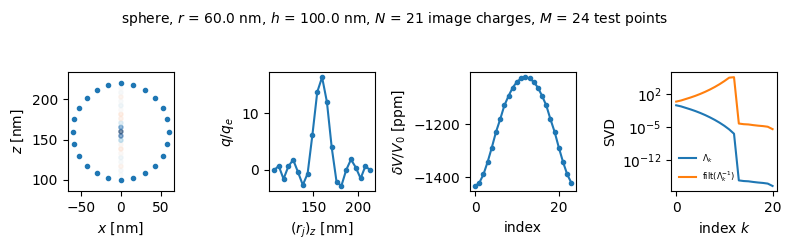

In [6]:
_ = obj1.plot()

In [7]:
obj1.properties_am(omega_m=1e5, omega_am=250.)

In [8]:
%timeit obj1.properties_am(omega_m=1e5, omega_am=250.)

91.7 ms ± 3.54 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Compute the BLDS spectrum.

In [9]:
omega_m = np.logspace(start=3,stop=6,num=40)

In [10]:
def properties_ac_spectrum(obj, omega_m):
    
    df = np.zeros_like(omega_m)
    for index, omega in enumerate(omega_m):
        obj.properties_ac(omega)
        df[index] = obj.results['Delta f ac [Hz]']
    return df 

In [11]:
df1 = properties_ac_spectrum(obj1, omega_m)

In [103]:
result = %timeit -o properties_ac_spectrum(obj1, omega_m)

t[1] = {'method': 'CPU ac',
        'time [s]': round(result.average, 3)}

1.18 s ± 23.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [104]:
t[1]

{'method': 'CPU ac', 'time [s]': 1.181}

Compute the BLDS spectrum with AM modulation assuming $\omega_{\mathrm{am}} = 250 \: \mathrm{Hz}$.

In [150]:
def properties_am_spectrum(obj, omega_m):
    
    df = np.zeros_like(omega_m)
    for index, omega in enumerate(omega_m):
        obj.properties_am(omega_m=omega, omega_am=250.)
        df[index] = obj.results['Delta f am [Hz]']
    return df 

In [151]:
df2 = properties_am_spectrum(obj1, omega_m)

In [152]:
result = %timeit -o properties_am_spectrum(obj1, omega_m)

t[2] = {'method': 'CPU am',
        'time [s]': round(result.average, 3)}

3.67 s ± 67 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [153]:
t[2]

{'method': 'CPU am', 'time [s]': 3.672}

Taking a few seconds to compute a BLDS spectrum is a significant improvement over the prior 30 seconds.  \
**This run time is still too slow for curve fitting**.

# Calculate the BLDS spectrum on the GPU

## A GPU `solve` function to obtain the $C$ and $K_n$ matrices

Create a mapping of `rp_III_integrator` onto the frequencyes $\omega$ and well as onto the $s_j$ and $r_k$ vectors.

In [14]:
KmatrixIIIw = \
torch.vmap(
    torch.vmap(
        torch.vmap(
            rp_III_integrator,
            in_dims=(None, None, None, None, None, 0, None, None),
            out_dims=0,
        ),
        in_dims=(None, None, None, None, 0, None, None, None),
        out_dims=0,
    ),
    in_dims=(0, None, None, None, None, None, None, None),
    out_dims=0,
)

Write a simplified `solve` function that returns `K0`, so we can check it's size.

In [15]:
class twodimCobjectExperimental(twodimCobject):

    def solve(self, omega_list):
        """Solve for the charges.  The parameter $\alpha$ is used to filter
        the singular values in the inverse.  The parameter omega is the unitless
        cantilever frequency in rad/s.       
        """
        
        sj = torch.as_tensor(self.sj.astype(np.float32), device=self.device)
        rk = torch.as_tensor(self.rk.astype(np.float32), device=self.device)
        
        Ctensor = Cmatrix(sj, rk)
        
        if self.sample.type == 3:
            
            omega0 = self.sample.omega0.to('Hz').magnitude
            kD = self.sample.kD.to('1/m').magnitude
            es = self.sample.epsilon_s.to('').magnitude
            
            K0tensor, K1tensor, K2tensor = KmatrixIIIw(omega_list, omega0, kD, es, sj, rk, self.pts, self.device)
            
        else:
            
            raise Exception("unknown sample type")
                
        K0 = K0tensor.cpu().numpy() 
        K1 = K1tensor.cpu().numpy()
        K2 = K2tensor.cpu().numpy()
        C = Ctensor.cpu().numpy()
        
        return C, K0, K1, K2

There is no `torch.logspace` function that runs on the M1 GPU. \
So use the `numpy` array to create the `torch` tensor.

In [16]:
omega_m_torch = torch.as_tensor(omega_m.astype(np.float32), device=device)

In [17]:
obj2 = twodimCobjectExperimental(sample3, device)
obj2.addsphere(ureg.Quantity(100,'nm'), 21, 24)
obj2.set_alpha(1.0e-6)
obj2.set_integration_points(21 * 15)
C, K0, K1, K2 = obj2.solve(omega_m_torch)

The tensor `K0` has the expected shape.

In [18]:
K0.shape

(40, 24, 21)

The time to compute *all* the $K_n$ matrices, one at each frequency, on the GPU:

In [19]:
%timeit obj2.solve(omega_m_torch)

24.5 ms ± 52.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


The time to compute the $K_n$ matrices at just *one* frequency on the CPU:

In [20]:
%timeit obj1.solve(1e3)

14.3 ms ± 444 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


We have clearly achieved a significant speed up.

## A CPU function to compute $(\Lambda_0, \Lambda_1, \Lambda_2)$, $V_{\mathrm{rms}}$, and $Q$

We have some more code to write. \
What do we do with the matrices? \
Compute the $(\Lambda_0, \Lambda_1, \Lambda_2)$ vectors.

In [21]:
obj2.info['M'], obj2.info['N']

(24, 21)

In [22]:
n, M, N = K0.shape
(n, M, N)

(40, 24, 21)

In [23]:
def reduce(C, K0, K1, K2, alpha, cGinv, cG):
    
    n, M, N = K0.shape
    
    L0 = np.zeros(n, dtype=np.complex64)
    L1 = np.zeros(n, dtype=np.complex64)
    L2 = np.zeros(n, dtype=np.complex64)
    Q = np.zeros((n,N), dtype=np.complex64)    
    Vrms = np.zeros(n, dtype=np.float32)
    Vones = np.ones(M, dtype=np.float32)
 
    
    G0 = C - K0
    
    for index in np.arange(n):
    
        U, S, VT = np.linalg.svd(G0[index,:,:], full_matrices=False)

        filt = np.diag(np.power(S, 2)/(np.power(S, 2) + alpha**2))
        Sinv = filt * np.diag(np.power(S, -1))
        G0inv = VT.T @ Sinv @ U.T

        IdN = np.ones(N).T
        IdM = np.ones(M)

        L0[index] = IdN @ G0inv @ IdM
        L1[index] = -2 * IdN @ G0inv @ K1[index,:,:] @ G0inv @ IdM
        L2[index] = 4 * IdN @ (G0inv @ K2[index,::] @ G0inv 
                    + 2 * G0inv @ K1[index,:,:] @ G0inv @ K1[index,:,:] @ G0inv) @ IdM     

        Q[index] = cGinv * complex(0,1) * G0inv @ IdM
        V = -1 * complex(0,1) * cG * G0[index,:,:] @ Q[index]
        
        Vrms[index] = np.std(V - Vones)
        
    return L0, L1, L2, Vrms, Q

In [24]:
L0, L1, L2, Vrms, Q = reduce(C, K0, K1, K2, obj2.alpha, obj2.cGinv, obj2.cG)

Wow is this fast!

In [25]:
%timeit reduce(C, K0, K1, K2, obj2.alpha, obj2.cGinv, obj2.cG)

3.88 ms ± 2.93 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Check that the CPU- and the GPU-computed $(\Lambda_0, \Lambda_1, \Lambda_2)$ vectors agree at the first and last $\omega_{\mathrm{m}}$ values.

In [26]:
s1 = np.array(obj1.solve(omega=omega_m[0]))
s2 = np.array([L0[0], L1[0], L2[0]])
comparetwoK(s1,s2)

Re[K[0]] +7.204130127e+01 vs +7.202091980e+01, relative error = +2.83e-04
Re[K[1]] -8.256420673e-02 vs -8.250392973e-02, relative error = +7.30e-04
Re[K[2]] +1.163217877e-03 vs +1.161952969e-03, relative error = +1.09e-03

Im[K[0]] +1.944180146e-01 vs +1.944218725e-01, relative error = -1.98e-05
Im[K[1]] +3.459711285e-04 vs +3.455829283e-04, relative error = +1.12e-03
Im[K[2]] -3.461569207e-06 vs -3.456118748e-06, relative error = +1.57e-03


In [27]:
s1 = np.array(obj1.solve(omega=omega_m[-1]))
s2 = np.array([L0[-1], L1[-1], L2[-1]])
comparetwoK(s1,s2)

Re[K[0]] +6.624166584e+01 vs +6.622640991e+01, relative error = +2.30e-04
Re[K[1]] -4.356110414e-02 vs -4.354437813e-02, relative error = +3.84e-04
Re[K[2]] +6.141382819e-04 vs +6.141656195e-04, relative error = -4.45e-05

Im[K[0]] +1.890261048e-01 vs +1.890257001e-01, relative error = +2.14e-06
Im[K[1]] +8.885094436e-04 vs +8.881139802e-04, relative error = +4.45e-04
Im[K[2]] -1.346843842e-05 vs -1.346034514e-05, relative error = +6.01e-04


## A CPU function to obtain the frequency shift

In [240]:
def compute_blds(obj, omega_m_torch):
    
    Cp, K0p, K1p, K2p = obj.solve(     omega_m_torch)
    Cm, K0m, K1m, K2m = obj.solve(-1 * omega_m_torch)
    
    L0p, L1p, L2p, _, _ = reduce(Cp, K0p, K1p, K2p, obj.alpha, obj.cGinv, obj.cG)
    L0m, L1m, L2m, _, _ = reduce(Cm, K0m, K1m, K2m, obj.alpha, obj.cGinv, obj.cG)
    
    V0 = obj.sample.cantilever.V_ts.to('V')
    fc = obj.sample.cantilever.f_c.to('Hz')
    kc = obj.sample.cantilever.k_c.to('N/m')
    
    c1 = 0.5 * np.pi * epsilon0 * V0**2
    Fac = c1 * np.imag(complex(0,1) * (L1p + L1m))     
    
    c2 = - 0.25 * (fc * np.pi * epsilon0 * V0**2) / (kc * obj.zr)
    dfac = c2 * (np.imag(complex(0,1) * (L2p + L2m)))
    
    return Fac.to('pN').magnitude, dfac.to('Hz').magnitude

In [241]:
Fac, df3 = compute_blds(obj2, omega_m_torch)

In [242]:
result = %timeit -o compute_blds(obj2, omega_m_torch)

t[3] = {'method': 'GPU ac',
        'time [s]': round(result.average, 3)}

56.9 ms ± 250 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [243]:
t[3]

{'method': 'GPU ac', 'time [s]': 0.057}

In [244]:
def compare_plot(omega_m, df1, df2, label1, label2, note=None):
    
    args = {'markerfacecolor': 'white', 
        'markeredgecolor': 'black', 
        'markersize': 3, 
        'color': 'black'}
    
    x = omega_m
    y1 = np.abs(df1)
    y2 = np.abs(df2)
    dy = (y1 - y2)/y1
    
    fig, (ax1, ax2) = plt.subplots(
        nrows=2, ncols=1, figsize=(3.5,4.5), sharex=True, 
        gridspec_kw={'hspace': 0, 'height_ratios': [1, 3]})
    
    ax1.semilogx(x, 1e3 * dy, 'o', **args)
    ax1.set_ylabel(r'$r_{\mathrm{norm}} \times 10^{3}$ ')
    
    ax2.semilogx(x, y1, 'k-', label=label1)
    ax2.semilogx(x, y2, 'o', **args, label=label2)

    ax2.legend()
    ax2.set_xlabel('modulation frequency $\omega_{\mathrm{m}}$ [Hz]')
    ax2.set_ylabel('frequency shift $|\Delta f_{\mathrm{ac}} (\omega_{\mathrm{m}})|$ [Hz]')
    
    ax2.yaxis.set_major_locator(plt.MaxNLocator(4))
    
    if note is not None:
        ax2.text(
            0.95, 
            0.95, 
            note,
            transform=ax2.transAxes,
            horizontalalignment='right',
            verticalalignment='top',
            fontsize=10,
            color='black'
        )             
    
    fig.subplots_adjust(hspace=0)
    fig.align_ylabels()
    fig.tight_layout()
    
    return fig  


Compare the AC frequency shift computed using the CPU and GPU methods.

In [245]:
label1 = '{:}, {:0.3f} s'.format(t[1]['method'], t[1]['time [s]'])
label2 = '{:}, {:0.3f} s'.format(t[3]['method'], t[3]['time [s]'])

note1 = r'$n_{\mathrm{pts}}$ =' + ' {:d}'.format(len(omega_m))
note2 = 'speedup = {:0.1f}x'.format(t[1]['time [s]']/t[3]['time [s]'])
note = note1 + '\n' + note2    

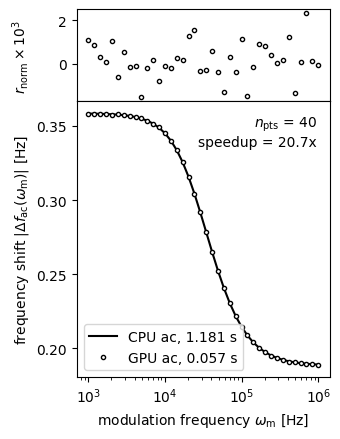

In [246]:
figs['01'] = compare_plot(omega_m, df1, df3, label1, label2, note)

Compare the AC frequency shift to the *scaled* AM frequency shift, both computed using the CPU. \
They are hardly different. 

In [281]:
label2 = r'{:} $\times$ 2.667, {:0.3f} s'.format(t[2]['method'], t[2]['time [s]'])
label1 = r'{:}, {:0.3f} s'.format(t[1]['method'], t[1]['time [s]'])

note1 = r'$n_{\mathrm{pts}}$ =' + ' {:d}'.format(len(omega_m))
note2 = 'speedup = {:0.1f}x'.format(t[2]['time [s]']/t[1]['time [s]'])
note = note1 + '\n' + note2    

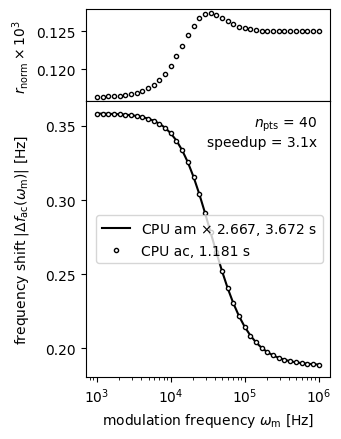

In [282]:
figs['02'] = compare_plot(omega_m, 2.667 * df2, df1, label2, label1, note)

Compare the AM frequency shift computed using the CPU and the AC frequency shift computed using the GPU. \
There is hardly any difference.

In [285]:
label1 = r'{:} $\times$ 2.667, {:0.3f} s'.format(t[2]['method'], t[2]['time [s]'])
label2 = r'{:}, {:0.3f} s'.format(t[3]['method'], t[3]['time [s]'])

note1 = r'$n_{\mathrm{pts}}$ =' + ' {:d}'.format(len(omega_m))
note2 = 'speedup = {:0.1f}x'.format(t[2]['time [s]']/t[3]['time [s]'])
note = note1 + '\n' + note2    

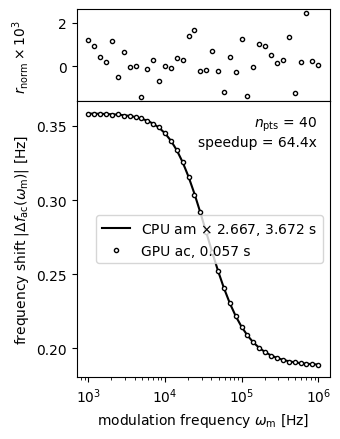

In [286]:
figs['03'] = compare_plot(omega_m, 2.667 * df2, df3, label1, label2, note)

**We can approximate the AM frequency shift by the AC frequency shift and reduce computation time by a factor of 3x.**

# Demonstrate curve fitting.

## Let $\epsilon^{\prime}$, $\sigma$, and $\rho$ vary

In [372]:
def func(omega_m, R, theta, epsilon, sigma, rho):

    cantilever = CantileverModel(
        f_c=ureg.Quantity(62, "kHz"),
        k_c=ureg.Quantity(2.8, "N/m"),
        V_ts=ureg.Quantity(1, "V"),
        R=ureg.Quantity(60, "nm"),
        angle=ureg.Quantity(20, "degree"),
        L=ureg.Quantity(1000, "nm"),
    )

    sample3 = SampleModel3(
        cantilever=cantilever,
        epsilon_s=ureg.Quantity(complex(epsilon, 0), ""),
        sigma=ureg.Quantity(sigma, "S/m"),
        rho=ureg.Quantity(rho, "1/m^3"),
        z_r=ureg.Quantity(1, "nm"),
    )
    
    obj = twodimCobjectExperimental(sample3, device)
    obj.addsphere(ureg.Quantity(100,'nm'), 21, 24)
    obj.set_alpha(1.0e-6)
    obj.set_integration_points(21 * 15)
    
    omega_m_torch = torch.as_tensor(omega_m.astype(np.float32), device=device)
    
    _, df3 = compute_blds(obj, omega_m_torch)
    
    return np.abs(df3)/2.667 # empirically determined constant

Compute the frequency shift using bad initial guesses.

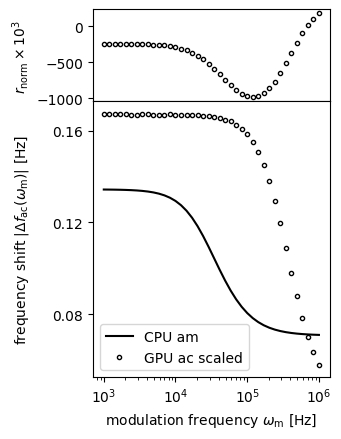

In [373]:
x_data = omega_m
y_data = np.abs(df2)
y_calc = func(x_data, 60, 20, 2.0, 1.0e-5, 1e22)

figs['04'] = compare_plot(x_data, y_data, y_calc, 'CPU am', 'GPU ac scaled')

Now try to curve fit.

In [376]:
model = Model(func)

pars1 = Parameters()
pars1.add('R', value=60.0, min=30, max=100, vary=False)
pars1.add('theta', value=20.0, min=15, max=30, vary=False)
pars1.add('epsilon', value=2.0, min=1, max=20, vary=True)
pars1.add('sigma', value=1.0e-5, min=1.0e-8, max=1.0e-4, vary=True)
pars1.add('rho', value=1e22, min=1e16, max=1e24, vary=True)

Run the fit using the default method. \
It does not converge to the right answer.

In [379]:
%%time
result1 = model.fit(y_data, params=pars1, omega_m=x_data)

CPU times: user 372 ms, sys: 54 ms, total: 426 ms
Wall time: 1.96 s


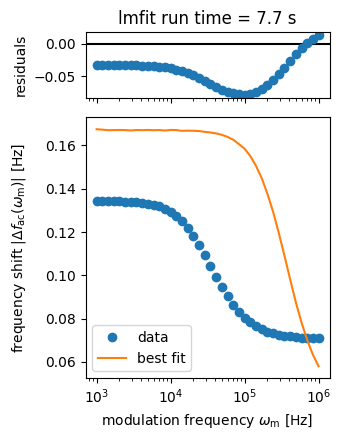

In [380]:
fig = plt.figure(figsize=(3.5,4.5))
fig = result1.plot(fig=fig,title='lmfit run time = 7.7 s')

fig.gca().set_xscale('log')
fig.gca().set_xlabel('modulation frequency $\omega_{\mathrm{m}}$ [Hz]')
fig.gca().set_ylabel('frequency shift $|\Delta f_{\mathrm{ac}} (\omega_{\mathrm{m}})|$ [Hz]')
fig.align_ylabels()
fig.tight_layout()

figs['05a'] = fig

Run the fit again using the "Nelder-Mead" method. \
It now converges.

In [381]:
%%time
result2 = model.fit(y_data, params=pars1, omega_m=x_data, method='Nelder-Mead')

CPU times: user 1.55 s, sys: 79.4 ms, total: 1.63 s
Wall time: 7.68 s


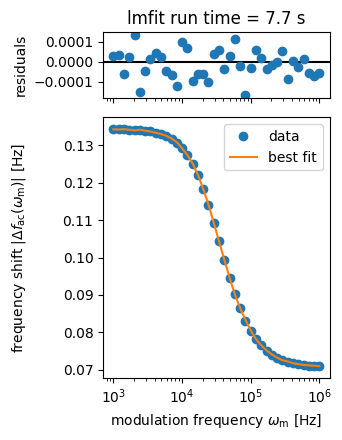

In [382]:
fig = plt.figure(figsize=(3.5,4.5))
fig = result2.plot(fig=fig,title='lmfit run time = 7.7 s')

fig.gca().set_xscale('log')
fig.gca().set_xlabel('modulation frequency $\omega_{\mathrm{m}}$ [Hz]')
fig.gca().set_ylabel('frequency shift $|\Delta f_{\mathrm{ac}} (\omega_{\mathrm{m}})|$ [Hz]')
fig.align_ylabels()
fig.tight_layout()

figs['05b'] = fig

In [383]:
result2

## Let $R$, $\theta$, $\epsilon^{\prime}$, $\sigma$, and $\rho$ vary

In [385]:
pars2 = Parameters()
pars2.add('R', value=30.0, min=30, max=100, vary=True)
pars2.add('theta', value=22.0, min=15, max=30, vary=True)
pars2.add('epsilon', value=2.0, min=1, max=20, vary=True)
pars2.add('sigma', value=1.0e-5, min=1.0e-8, max=1.0e-4, vary=True)
pars2.add('rho', value=1e22, min=1e16, max=1e24, vary=True)

This fit takes much longer to run.

In [386]:
%%time
result3 = model.fit(y_data, params=pars2, omega_m=x_data, method='Nelder-Mead')

CPU times: user 3.43 s, sys: 223 ms, total: 3.65 s
Wall time: 18.2 s


The fit looks good.

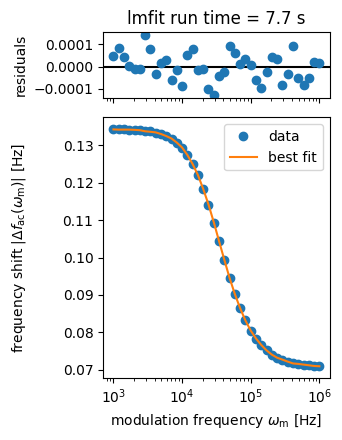

In [387]:
fig = plt.figure(figsize=(3.5,4.5))
fig = result3.plot(fig=fig,title='lmfit run time = 7.7 s')

fig.gca().set_xscale('log')
fig.gca().set_xlabel('modulation frequency $\omega_{\mathrm{m}}$ [Hz]')
fig.gca().set_ylabel('frequency shift $|\Delta f_{\mathrm{ac}} (\omega_{\mathrm{m}})|$ [Hz]')
fig.align_ylabels()
fig.tight_layout()

figs['05c'] = fig

The fit is very good. \
The best-sample parameters are very close to the expected values. \
The best-fit radius and cone angle of (34 nm, 22 degree) are quire different from the expected (60 nm, 20 degrees). \
The tip-sample separation here was 100 nm. \
Perhaps at that distance the frequency shift is insensitive to tip radius.

In [388]:
result3

# Conclusions

I used `vmap` to compute the $C$ and $K_n$ matrices at many positions *and* frequencies together on the GPU.  This innovation enabled the calculation of the AC frequency shift 64 times faster than the previous CPU-based calculation. An additional factor of three speed-up was realized by approximating the AM frequency shift as a scaled version of the AC frequency shift.

I then demonstrated that the new GPU-based code can compute a BLDS frequency shift fast enough to enable least-squares fitting of data.  To do this, I used the existing CPU-based code to compute the frequency shift in an AM modulation experiment; this frequency shift was treated as an articifial signal. I fit this artificial signal to a scaled AC frequency shift, computed using the new GPU code. This fit recovered the expected sample dielectric constant, conductivity, and charge density in under 20 seconds.

For comparison, the CPU-based code on my older labtop required 30 seconds to compute a single BLDS spectum.  Considering that the above fit made 303 function evaluations, the estimated time to fit a spectrum using the CPU-based code running on my older laptop is approximately 2.5 hours.  By moving to a new laptop and using GPU-based code, I have achieved a 450-fold reduction in fitting time. 

*Next steps*

1. Incorporate the functions `KmatrixIIIw`, `twodimCobjectExperimental.solve`, `reduce`, `compute_blds`, and the curve-fitting function into stand-alone python code.  
2. Unit test the computed $K_n$ integrals against `scipy.integrate` computations.
3. Extend the above results to model a Type I sample.
4. Again, unit test the computed $K_n$ integrals against `scipy.integrate` computations.

::: {.content-hidden when-format="html"}

# Save the figures

In [389]:
if 1:
    for num in figs.keys():
        figname = THIS + "Fig-" + num
        figs[num].savefig(figname + '.png', dpi=300)
        figs[num].savefig(figname + '.pdf')

# Formatting notes

The header at the top of this file is for creating a nicely-formatted `.html` document using the program `quarto` ([link](https://quarto.org/)).  To create nicely-formated `.html`versions of this notebook, run `quarto` from the command line as follows

    quarto render dissipation-theory--Study-69.ipynb && open dissipation-theory--Study-69.html
    
:::